In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.quantization
from tqdm import tqdm 
from torch.nn.utils import prune

In [2]:
def plot_loss(train_losses, test_losses, subtitle="", model_name=""):

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the training and testing loss
    ax.plot(train_losses, label='Training Loss', color='blue', linewidth=1.5)
    ax.plot(test_losses, label='Testing Loss', color='orange', linewidth=1.5)

    # Set title and labels with appropriate font sizes
    ax.set_title(f"Loss Over Epochs -- {model_name}", fontsize=18, pad=20)
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('Loss', fontsize=16)

    # Add the subtitle if provided
    if subtitle:
        ax.text(0.5, 1.03, subtitle, fontsize=12, ha='center', va='center', transform=ax.transAxes)

    # Set the legend with a modest font size and without a frame
    ax.legend(fontsize=14, frameon=False)

    # Add grid lines for better readability and aesthetics
    ax.grid(True, linestyle='--', alpha=0.5, which='major')

    # Improve layout to avoid cutting off information and to adjust padding
    plt.tight_layout(pad=1.5)

    # Show the plot
    plt.show()


In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_time(T, subtitle="", model_name=""):

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the histogram
    n, bins, patches = ax.hist(T, bins=50, density=False, alpha=0.7, color='blue', edgecolor='black', label='Inference Time')

    # Find the peak value and its corresponding bin
    peak_value = np.max(n)
    peak_index = np.argmax(n)
    peak_bin_center = (bins[peak_index] + bins[peak_index + 1]) / 2

    # Plot a vertical line at the peak value
    ax.axvline(x=peak_bin_center, color='red', linestyle='--', linewidth=2, label=f'Peak Value: {peak_bin_center:.5f}s')

    # Set title and labels with appropriate font sizes
    ax.set_title(f'Inference Time Distribution -- {model_name}', fontsize=18, pad=20)
    ax.set_xlabel('Inference Time (s)',fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)

    # Add the subtitle if provided, adjusting its position to avoid overlap
    if subtitle:
        ax.text(0.5, 1.03, subtitle, fontsize=12, ha='center', va='center', transform=ax.transAxes)

    # Set the legend with a modest font size and without a frame
    ax.legend(fontsize=14, frameon=False)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.5, which='major')

    # Improve layout to avoid cutting off information and to adjust padding
    plt.tight_layout(pad=1.5)

    # Show the plot
    plt.show()



In [4]:
def train_model_qat(model, train_loader, test_loader, lr, num_epochs):
    model.train()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_losses = []
    test_losses = []
    timing = {'quant_time': 0, 'fc_time': 0, 'dequant_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs, quant_time, fc_time, dequant_time = model(inputs)
            
            # Accumulate the timing information
            timing['quant_time'] += quant_time
            timing['fc_time'] += fc_time
            timing['dequant_time'] += dequant_time

            # Compute training loss
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))
        # print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss / len(train_loader)}")

        # Evaluation loop on test set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs, _, _, _ = model(inputs)
                test_loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += test_loss.item()
        
        # Compute average test loss
        test_losses.append(epoch_test_loss / len(test_loader))
        # print(f"Epoch {epoch+1}, Test Loss: {epoch_test_loss / len(test_loader)}")

        model.train()  # Set model back to training mode

    return train_losses, test_losses, timing, model              

In [5]:
import torch
import numpy as np
import time

def inference_time(model_qat, test_loader):
    """
    Calculate the inference time for a quantized model.

    Args:
    model_qat (torch.nn.Module): Quantized model.
    test_loader (torch.utils.data.DataLoader): DataLoader for test dataset.

    Returns:
    T_qat (numpy.ndarray): Array containing the inference times.
    accuracy (float): Accuracy of the model.
    predict_time (float): Average prediction time.
    """

    model_qat.eval()
    T_qat = []

    y_pre = []
    correct = 0
    total = 0
    times = 0

    for _ in range(200):
        times = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                stt = time.time()
                outputs, _, _, _ = model_qat(inputs)
                ent = time.time()
                times += ent - stt
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_pre.append(predicted)
        T_qat.append(times)

    T_qat = np.array(T_qat)
    
    accuracy = correct / total
    predict_time = times / len(test_loader)
    
    print(f'Accuracy: {accuracy}')
    print(f'Predict time: {predict_time}')
    
    return T_qat, accuracy, predict_time


# Load Data

In [23]:
batch = 1024

In [24]:
df = pd.read_parquet('/workspaces/Acc-Higgs-HLS4ML/ML model/df.parquet')
X = pd.read_parquet('/workspaces/Acc-Higgs-HLS4ML/ML model/x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


In [74]:
num_epochs = 40
layers = [64, 32, 16]
lr = 0.001

# Original

In [75]:
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2], 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        timings = {}

        start_time = time.time()
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        timings['fc_time'] = time.time() - start_time

        x = self.sigmoid(self.layer3(x))
        
        return x, timings['fc_time']
model = BinaryClassificationModel()

In [76]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, test_loader, lr, num_epochs):
    model.train()
    criterion = nn.BCELoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_losses = []
    test_losses = []
    timing = {'fc_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs, fc_time = model(inputs)
            timing['fc_time'] += fc_time
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loop (test set)
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs, _ = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += loss.item()

        # Compute average test loss
        test_losses.append(epoch_test_loss / len(test_loader))

        model.train()

    return train_losses, test_losses, timing, model


In [77]:
# Train the model
train_losses, test_losses, timing, model = train_model(model, train_loader, test_loader, lr, num_epochs)

Epochs: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


In [212]:
model

BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=64, bias=True)
  (layer1): Linear(in_features=64, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
np.save("train_losses.npy", train_losses)
np.save("test_losses.npy", test_losses)

NameError: name 'train_losses' is not defined

In [8]:
train_losses = np.load("train_losses.npy")
test_losses = np.load("test_losses.npy")

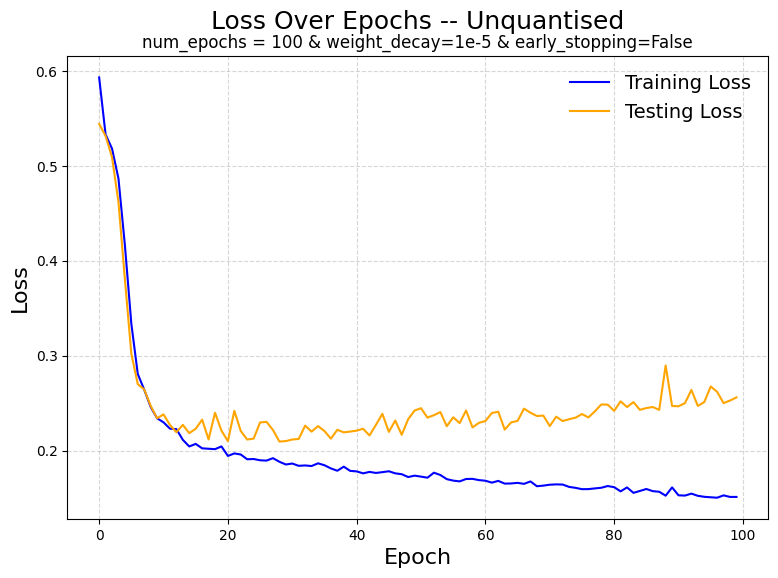

In [11]:
plot_loss(train_losses, test_losses, subtitle='num_epochs = 100 & weight_decay=1e-5 & early_stopping=False', model_name= "Unquantised")

In [78]:
# save the model
torch.save(model.state_dict(), 'model_Small.pth')

In [39]:
model.eval()
y_pre = []
T = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _ = model(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T.append(times)
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9183333333333333
Predict time: 0.011362314224243164


In [15]:
# save the T
np.save("T.npy", T)

In [12]:
T = np.load("T.npy")

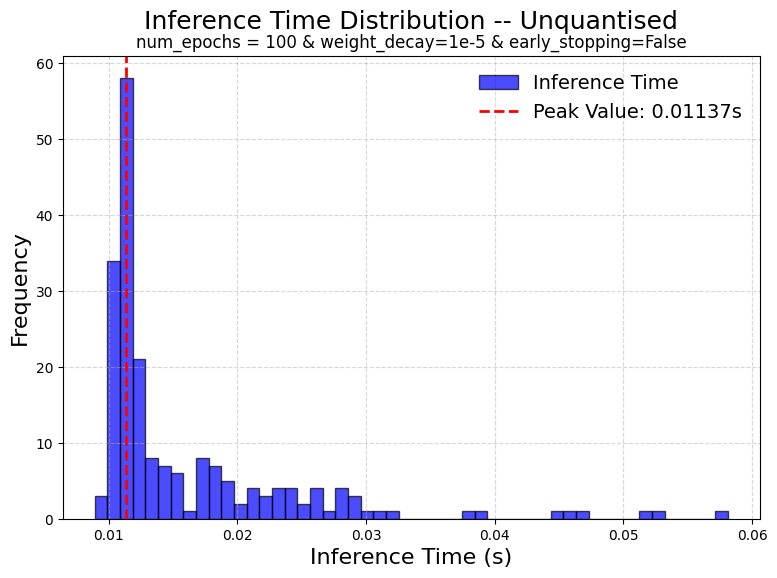

In [17]:
plot_time(T, subtitle='num_epochs = 100 & weight_decay=1e-5 & early_stopping=False', model_name="Unquantised")

In [119]:
# Save figure
plt.savefig('inference_time_distribution_with_peak_Original_Small.pdf', dpi=300)  # Save figure with higher resolution for publication

<Figure size 640x480 with 0 Axes>

### add early stopping
increase weight_decay=1e-3

In [43]:
model_es = BinaryClassificationModel()

In [44]:
def train_model_es(model, train_loader, test_loader, lr, num_epochs, patience=10):
    model.train()
    criterion = nn.BCELoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    train_losses = []
    test_losses = []
    timing = {'fc_time': 0}
    best_test_loss = float('inf')
    no_improvement_count = 0

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs, fc_time = model(inputs)
            timing['fc_time'] += fc_time
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loop (test set)
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs, _ = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += loss.item()

        # Compute average test loss
        test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(test_loss)

        # Check for early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f'Early stopping at epoch {epoch} as test loss did not improve for {patience} consecutive epochs.')
                break

        model.train()

    return train_losses, test_losses, timing, model


In [45]:
# Train the model
train_losses_es, test_losses_es, timing, model = train_model_es(model_es, train_loader, test_loader, lr, num_epochs, patience=20)

Epochs:  69%|██████▉   | 69/100 [01:05<00:29,  1.05it/s]

Early stopping at epoch 69 as test loss did not improve for 20 consecutive epochs.


In [213]:
model

BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=64, bias=True)
  (layer1): Linear(in_features=64, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [193]:
# save model 
torch.save(model.state_dict(), 'model_es.pth')

In [82]:
np.save("train_losses_es.npy", train_losses_es)
np.save("test_losses_es.npy", test_losses_es)

NameError: name 'train_losses_es' is not defined

In [18]:
train_losses_es = np.load("train_losses_es.npy")
test_losses_es = np.load("test_losses_es.npy")

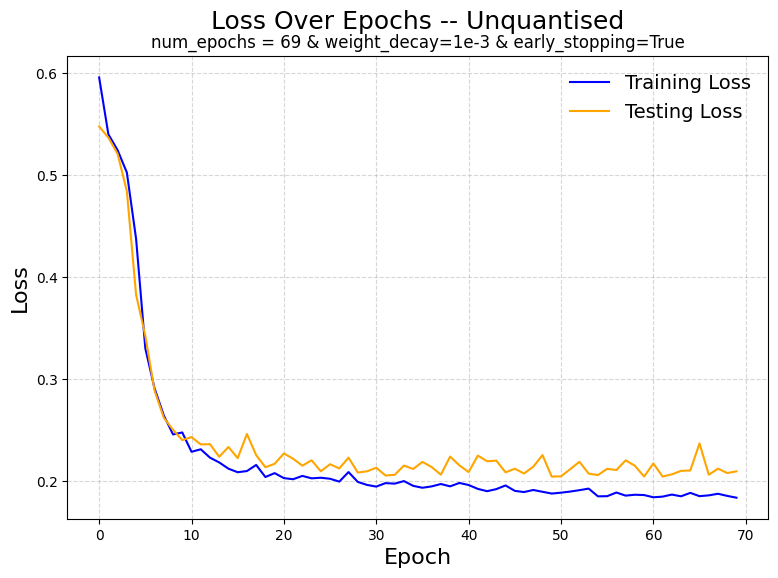

In [19]:
plot_loss(train_losses_es, test_losses_es,subtitle="num_epochs = 69 & weight_decay=1e-3 & early_stopping=True",  model_name= "Unquantised")

In [50]:
model_es.eval()
y_pre = []
T_es = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _ = model_es(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_es.append(times)
T_es= np.array(T_es)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9193333333333333
Predict time: 0.017952680587768555


In [157]:
# save the T
np.save("T_es.npy", T_es)

In [20]:
T_es = np.load("T_es.npy")

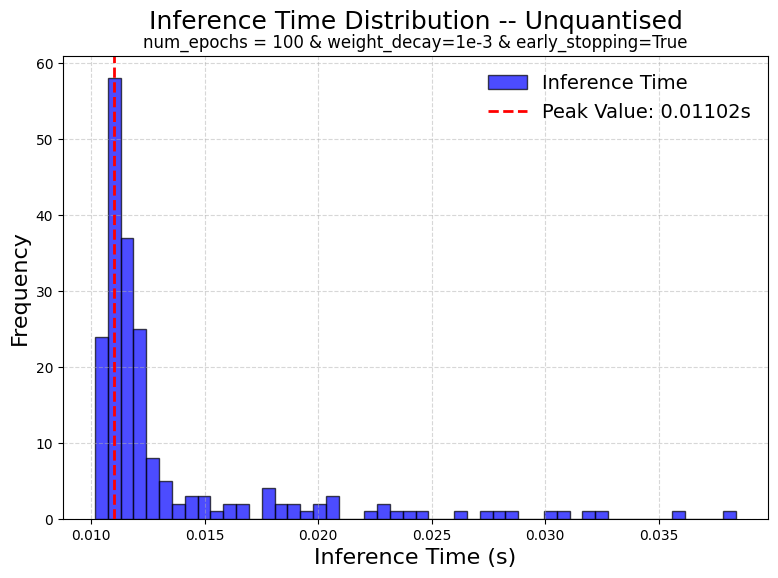

In [23]:
plot_time(T_es, subtitle="num_epochs = 100 & weight_decay=1e-3 & early_stopping=True", model_name= "Unquantised")

In [22]:
# Save figure
plt.savefig('inference_time_distribution_with_peak_Original_es.pdf', dpi=300) 

<Figure size 640x480 with 0 Axes>

### increase batch size to 1000

In [11]:
batch = 1000

In [12]:
train_loader1 = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader1 = DataLoader(test_data, batch_size=batch, shuffle=False)


In [13]:
model1 = BinaryClassificationModel()
# Train the model
train_losses1, test_losses1, timing1, model1 = train_model(model1, train_loader1, test_loader1, lr, num_epochs)

Epochs: 100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


In [14]:
model1

BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=64, bias=True)
  (layer1): Linear(in_features=64, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [15]:
np.save("train_losses1.npy", train_losses1)
np.save("test_losses1.npy", test_losses1)

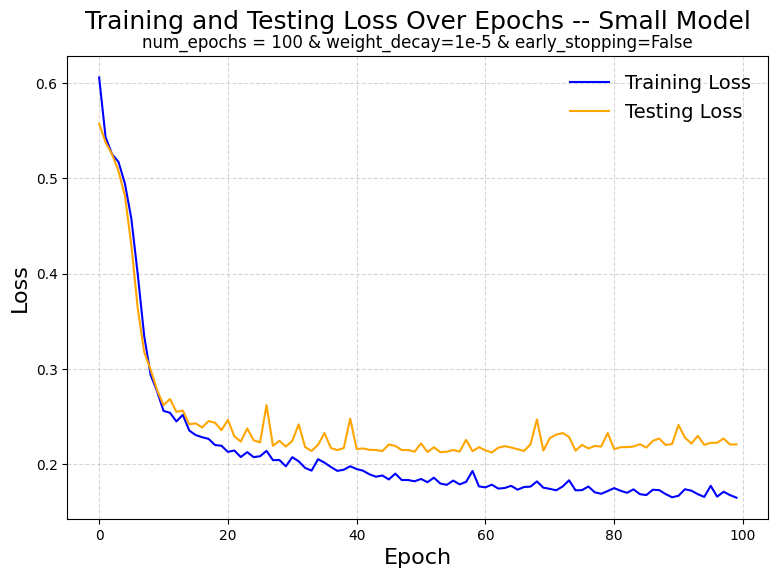

In [138]:
plot_loss(train_losses1, test_losses1, subtitle='num_epochs = 100 & weight_decay=1e-5 & early_stopping=False')

In [16]:
model1.eval()
y_pre = []
T1 = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader1:
            stt= time.time()
            outputs, _ = model1(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T1.append(times)
T1= np.array(T1)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.92025
Predict time: 0.010328292846679688


In [17]:
# save the T
np.save("T1.npy", T1)

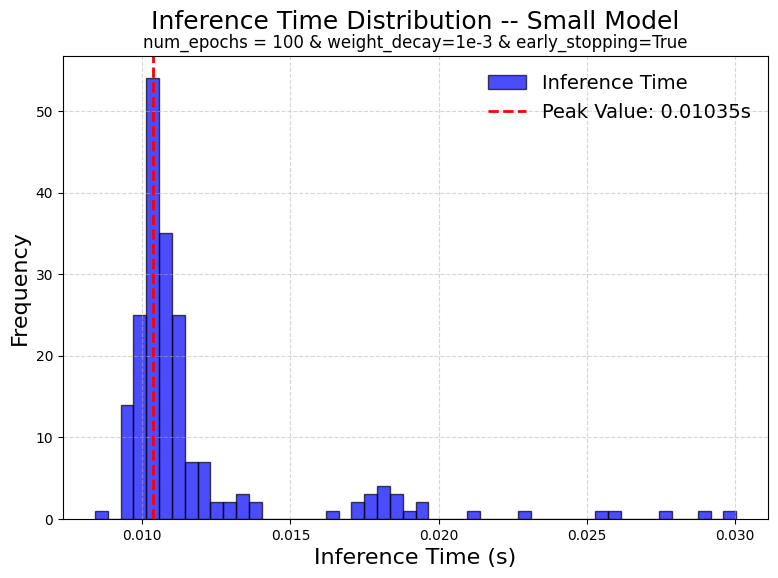

In [182]:
plot_time(T1, subtitle="num_epochs = 100 & weight_decay=1e-3 & early_stopping=True")

# QAT

In [25]:
num_epochs = 100
layers = [64, 32, 16]
lr = 0.001

In [26]:
class BinaryClassificationModelQ(nn.Module):
    def __init__(self):
        super(BinaryClassificationModelQ, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2], 1)
        self.sigmoid = nn.Sigmoid()
        self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, x):
        timings = {}
        
        start_time = time.time()
        x = self.quant(x)
        timings['quant_time'] = time.time() - start_time

        start_time = time.time()
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        timings['fc_time'] = time.time() - start_time

        start_time = time.time()
        x = self.sigmoid(self.layer3(x))
        x = self.dequant(x)
        timings['dequant_time'] = time.time() - start_time

        return x, timings['quant_time'], timings['fc_time'], timings['dequant_time']

modelQ = BinaryClassificationModelQ()
modelQ.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ, inplace=True)


/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=64, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_ena

In [27]:
# Train the x
train_losses_qat, test_losses_qat, timing_qat, model_qat = train_model_qat(modelQ, train_loader, test_loader, lr, num_epochs)

Epochs: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


In [28]:
np.save("train_losses_qat.npy", train_losses_qat)
np.save("test_losses_qat.npy", test_losses_qat)

In [29]:
train_losses_qat = np.load("train_losses_qat.npy")
test_losses_qat = np.load("test_losses_qat.npy")

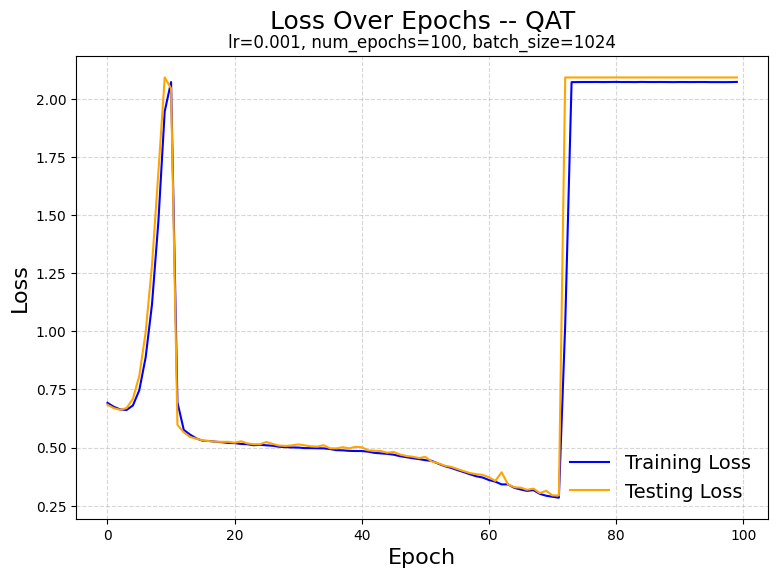

<Figure size 640x480 with 0 Axes>

In [30]:
# plot the loss
plot_loss(train_losses_qat, test_losses_qat, subtitle='lr=0.001, num_epochs=100, batch_size=1024',  model_name= "QAT")
# save the image
plt.savefig("QAT_loss.pdf")

In [31]:
# save the model
torch.save(model_qat.state_dict(), 'model_q.pth')

In [32]:
model_qat.eval()
y_pre = []
T_qat = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_qat.append(times)
T_qat= np.array(T_qat)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.62325
Predict time: 0.03042125701904297


In [33]:
# save the T
np.save("T_qat.npy", T_qat)

In [102]:
T_qat = np.load("T_qat.npy")

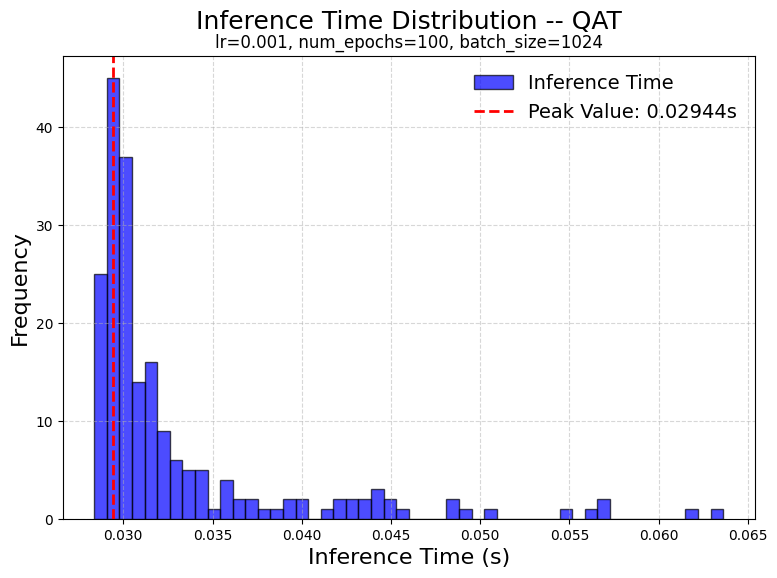

In [103]:
plot_time(T_qat, subtitle='lr=0.001, num_epochs=100, batch_size=1024', model_name= "QAT")

In [90]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs, _, _, _ = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

In [39]:
AUC(model_qat, test_loader)

AUC = 0.5


### num epoch = 500

In [40]:
num_epochs = 500
layers = [64, 32, 16]
lr = 0.001

In [41]:
modelQ5 = BinaryClassificationModelQ()
modelQ5.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ5, inplace=True)

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=64, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_ena

In [42]:
train_losses_qat5, test_losses_qat5, timing_qat5, model_qat5 = train_model_qat(modelQ5, train_loader, test_loader, lr, num_epochs = 500)

Epochs: 100%|██████████| 500/500 [05:44<00:00,  1.45it/s]


In [43]:
np.save("train_losses_qat5.npy", train_losses_qat5)
np.save("test_losses_qat5.npy", test_losses_qat5)

In [44]:
train_losses_qat5 = np.load("train_losses_qat5.npy")
test_losses_qat5 = np.load("test_losses_qat5.npy")

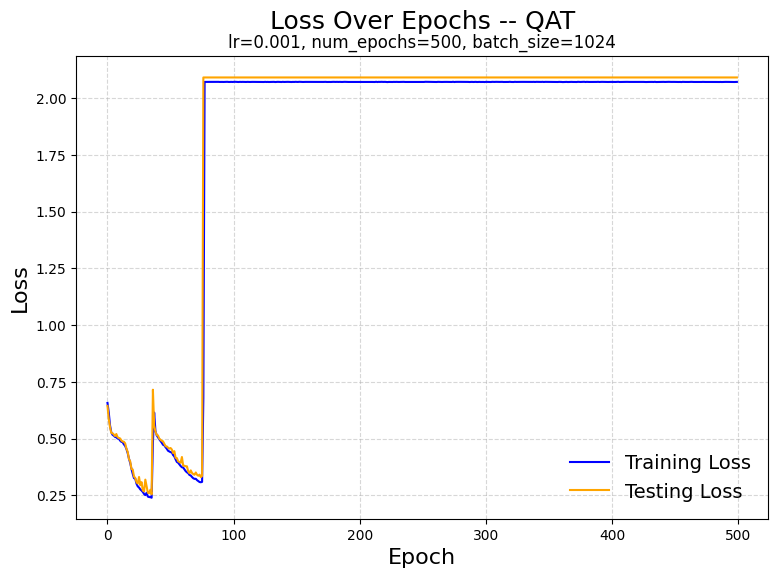

<Figure size 640x480 with 0 Axes>

In [45]:
# plot the loss
plot_loss(train_losses_qat5, test_losses_qat5, subtitle='lr=0.001, num_epochs=500, batch_size=1024',  model_name= "QAT")
# save the image
plt.savefig("QAT_loss.pdf")

In [46]:
model_qat5.eval()
y_pre = []
T_qat5 = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat5(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_qat5.append(times)
T_qat5= np.array(T_qat5)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.62325
Predict time: 0.03535151481628418


In [162]:
# save the T
np.save("T_qat5.npy", T_qat5)

In [12]:
T_qat5 = np.load("T_qat5.npy")

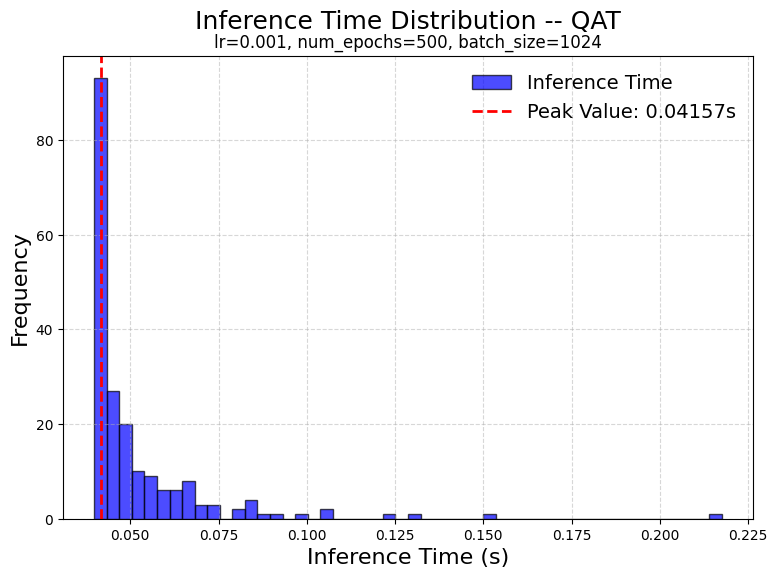

In [13]:
plot_time(T_qat5, subtitle='lr=0.001, num_epochs=500, batch_size=1024',  model_name= "QAT")

In [58]:
AUC(model_qat5, test_loader)

AUC = 0.5


In [47]:
num_epochs = 40
layers = [64, 32, 16]
lr = 0.001

In [48]:
modelQ5 = BinaryClassificationModelQ()
modelQ5.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ5, inplace=True)

BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=64, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_ena

In [50]:
train_losses_qat4, test_losses_qat4, timing_qat4, model_qat4 = train_model_qat(modelQ5, train_loader, test_loader, lr, num_epochs = 40)

Epochs: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


In [51]:
np.save("train_losses_qat4.npy", train_losses_qat4)
np.save("test_losses_qat4.npy", test_losses_qat4)

In [52]:
train_losses_qat4 = np.load("train_losses_qat4.npy")
test_losses_qat4 = np.load("test_losses_qat4.npy")

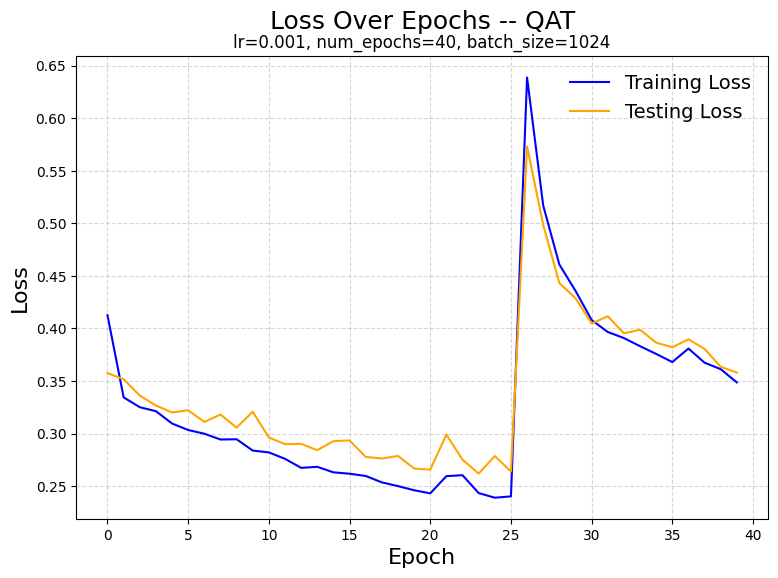

<Figure size 640x480 with 0 Axes>

In [53]:
# plot the loss
plot_loss(train_losses_qat4, test_losses_qat4, subtitle='lr=0.001, num_epochs=40, batch_size=1024',  model_name= "QAT")
# save the image
plt.savefig("QAT_loss49.pdf")

In [54]:
model_qat4.eval()
y_pre = []
T_qat4 = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat4(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_qat4.append(times)
T_qat4= np.array(T_qat4)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.815
Predict time: 0.05513620376586914


In [55]:
# save the T
np.save("T_qat4.npy", T_qat4)

In [56]:
T_qat4 = np.load("T_qat4.npy")

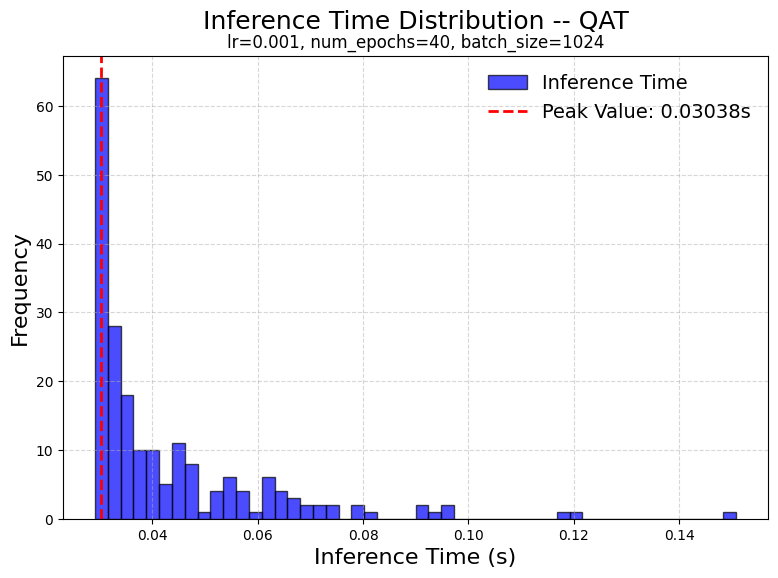

In [57]:
plot_time(T_qat4, subtitle='lr=0.001, num_epochs=40, batch_size=1024',  model_name= "QAT")

In [59]:
AUC(model_qat4, test_loader)

AUC = 0.9085142890249744


### add earling stoppping


In [60]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

def train_model_qat_es(model, train_loader, test_loader, lr, num_epochs, early_stopping_patience=80):
    model.train()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_losses = []
    test_losses = []
    timing = {'quant_time': 0, 'fc_time': 0, 'dequant_time': 0}
    
    # Early stopping initialization
    best_test_loss = float('inf')
    epochs_no_improve = 0

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            outputs, quant_time, fc_time, dequant_time = model(inputs)
            
            # Accumulate the timing information
            timing['quant_time'] += quant_time
            timing['fc_time'] += fc_time
            timing['dequant_time'] += dequant_time

            # Compute training loss
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Compute average training loss
        train_losses.append(epoch_train_loss / len(train_loader))

        # Evaluation loop on test set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
                outputs, _, _, _ = model(inputs)
                test_loss = criterion(outputs.squeeze(), labels.float())
                epoch_test_loss += test_loss.item()
        
        # Compute average test loss
        average_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(average_test_loss)

        # Early stopping check
        if average_test_loss < best_test_loss:
            best_test_loss = average_test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break  # Stop training loop

        model.train()  # Set model back to training mode

    return train_losses, test_losses, timing, model


In [61]:
modelQ_es = BinaryClassificationModelQ()
modelQ_es.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ_es, inplace=True)

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=64, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_ena

In [62]:
num_epochs = 150

In [63]:
train_losses_qat_es, test_losses_qat_es, timing_qat_es, model_qat_es = train_model_qat_es(modelQ_es, train_loader, test_loader, lr, num_epochs, early_stopping_patience=20)

Epochs:  45%|████▌     | 68/150 [00:48<00:58,  1.39it/s]

Early stopping triggered after 69 epochs.


In [64]:
np.save("train_losses_qat_es.npy", train_losses_qat_es)
np.save("test_losses_qat_es.npy", test_losses_qat_es)

In [65]:
train_losses_qat_es = np.load("train_losses_qat_es.npy")
test_losses_qat_es = np.load("test_losses_qat_es.npy")

In [92]:
# save the model
torch.save(model_qat_es.state_dict(), 'model_qat_es.pth')

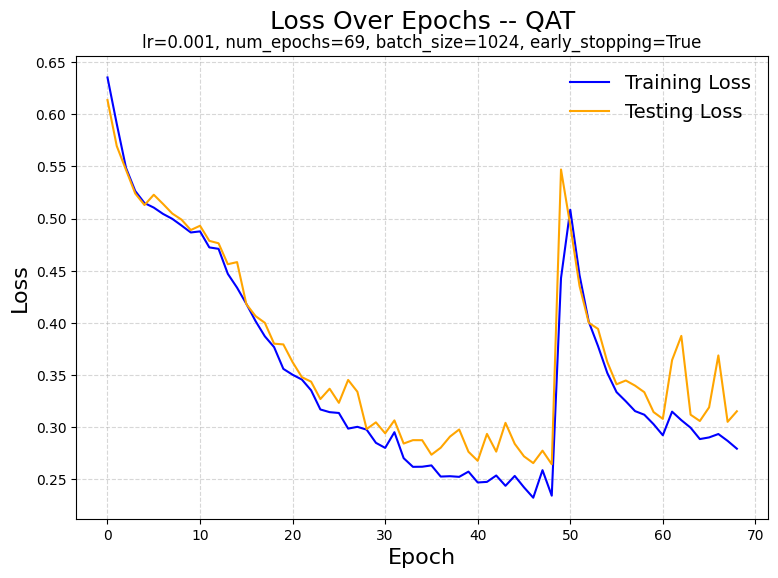

In [67]:
# plot the loss
plot_loss(train_losses_qat_es, test_losses_qat_es, subtitle='lr=0.001, num_epochs=69, batch_size=1024, early_stopping=True',  model_name= "QAT")


In [68]:
model_qat_es.eval()
y_pre = []
T_qat_es = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat_es(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T_qat_es.append(times)
T_qat_es= np.array(T_qat_es)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.8695
Predict time: 0.028578996658325195


In [69]:
# save the T
np.save("T_qat_es.npy", T_qat_es)

In [70]:
T_qat_es = np.load("T_qat_es.npy")

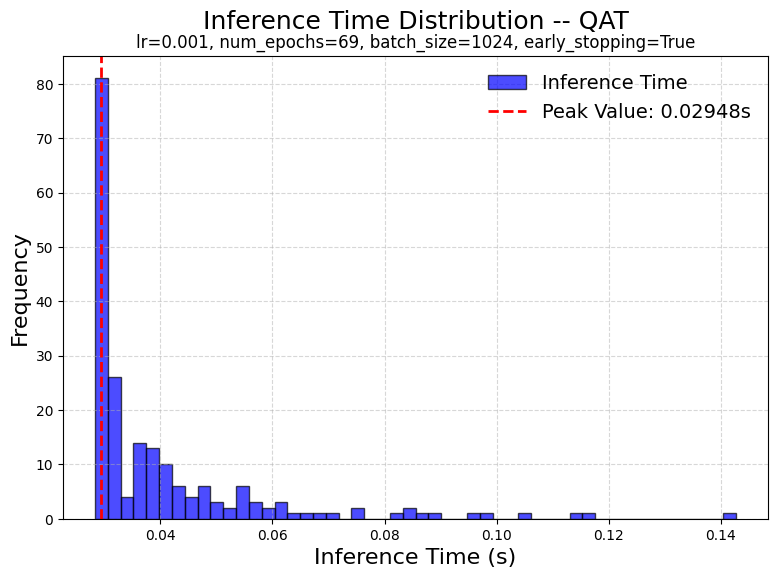

In [72]:
plot_time(T_qat_es, subtitle='lr=0.001, num_epochs=69, batch_size=1024, early_stopping=True',  model_name= "QAT")

In [91]:
AUC(model_qat_es, test_loader)

AUC = 0.9384682034861662


# PTQ

In [79]:
# load the trained model which applied the early stopping 
model_ptq = BinaryClassificationModel()
model_ptq.load_state_dict(torch.load("model_Small.pth"))

<All keys matched successfully>

In [80]:
model_ptq.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model_ptq,  
    {nn.Linear},  
    dtype=torch.qint8
)
quantized_model.eval()

BinaryClassificationModel(
  (layer0): DynamicQuantizedLinear(in_features=140, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer1): DynamicQuantizedLinear(in_features=64, out_features=32, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer2): DynamicQuantizedLinear(in_features=32, out_features=16, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer3): DynamicQuantizedLinear(in_features=16, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (sigmoid): Sigmoid()
)

In [81]:
quantized_model.eval()
y_pre = []
QT = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _ = quantized_model(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        QT.append(times)
QT= np.array(QT)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9079166666666667
Predict time: 0.007012367248535156


In [88]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs, _ = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

In [89]:
AUC(quantized_model, test_loader)

AUC = 0.9627967821069088


In [84]:
# save the T
np.save("QT.npy", QT)

In [85]:
QT = np.load("QT.npy")

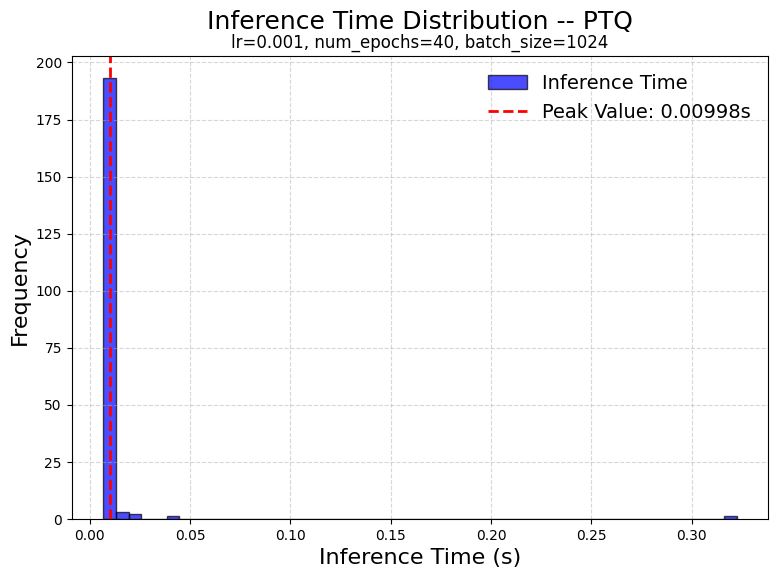

In [83]:
plot_time(QT, subtitle="lr=0.001, num_epochs=40, batch_size=1024",  model_name= "PTQ")

# COmbine them together?

In [93]:
model_qat_ptq = BinaryClassificationModelQ()
model_qat_ptq.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model_qat_ptq, inplace=True)
model_qat_ptq.load_state_dict(torch.load("model_qat_es.pth"))

/home/codespace/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


<All keys matched successfully>

In [94]:
model_qat_ptq.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model_qat_ptq, inplace=True)

BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.3066]), zero_point=tensor([28], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=-8.446122169494629, max_val=30.496706008911133)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=64, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([2.5340e-03, 1.8161e-03, 6.1000e-05, 2.2105e-03, 2.1522e-03, 2.0443e-03,
              2.5256e-03, 1.9627e-03, 1.5653e-03, 1.8765e-03, 6.5220e-04, 1.9848e-04,
              2.5385e-03, 1.8537e-04, 2.7204e-03, 2.0073e-03, 1.7641e-03, 6.1000e-05,
              6.1000e-05, 1.3188e-04, 1.8317e-03, 6.1000e-05, 3.0246e-03, 3.

In [100]:
AUC(model_qat_ptq, test_loader)

AUC = 0.9383255937534926


In [95]:
model_qat_ptq.eval()
y_pre = []
QQT = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat_ptq(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        QQT.append(times)
QQT= np.array(QQT)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.8685833333333334
Predict time: 0.03894782066345215


In [96]:
# save the T
np.save("QQT.npy", QQT)

In [97]:
QQT = np.load("QQT.npy")

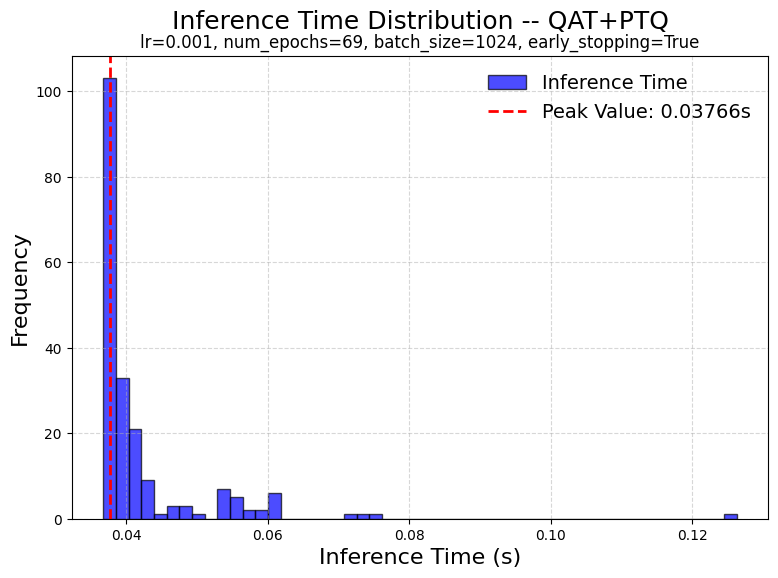

In [101]:
plot_time(QQT, subtitle="lr=0.001, num_epochs=69, batch_size=1024, early_stopping=True",  model_name= "QAT+PTQ")